In [1]:
from keras.models import Model
from keras.layers import LSTM, Input
from keras.utils.np_utils import to_categorical
from PointerLSTM import PointerLSTM as Pointerv0
import numpy as np

from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import keras.backend as K
from keras.activations import tanh, softmax
from keras.layers import RNN, LSTM, LSTMCell, Dense, Layer, Masking
import keras

In [5]:
def order(X, by_idx=False):
    # Are these the same?!
    # Ip => Index I occupying pth position
    y = X.argsort()

    if not by_idx:
        return y

    # Pi => Position P for ith index
    return y.argsort()

In [6]:
def gen_seq(**kwargs):
    X = np.random.randint(**kwargs)

    def _order(order_by_idx=False):
        y = order(X, order_by_idx)
        return X, y

    return _order

In [7]:
def gen_data(N, seq_len, order_by_idx=False, low=0, high=100):
    seq_gen = gen_seq(low=low, high=high, size=(N, seq_len))

    X, y = seq_gen(order_by_idx=False)
    return X, y

In [44]:
class Attention(Layer):
    def __init__(self, units, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.W1 = Dense(units, use_bias=False)
        self.W2 = Dense(units, use_bias=False)
        self.V = Dense(1, use_bias=False)
        self.supports_masking = True

    def call(self, X_enc, X_dec, mask=None):
        # print('Att. mask:', mask, self.supports_masking)
        h_enc = self.W1(X_enc)
        h_dec = self.W1(X_dec)
        h_dec = K.repeat(h_dec, h_enc.shape[1])

        u = tanh(h_enc + h_dec)
        u = self.V(u)
        u = K.squeeze(u, axis=2)

        if mask is not None:
            mask_values = K.cast(mask[0], u.dtype)
            u += (1-mask_values) * K.constant(-1e20) # -np.infty
                
        a = softmax(u, axis=1)
        return a

In [45]:
class PointerLSTMCell(LSTMCell):
    def __init__(self, units, **kwargs):
        super(PointerLSTMCell, self).__init__(units, **kwargs)
        self.attention = Attention(units)
        self.supports_masking = True

    def call(self, inputs, states, constants=None, mask=None, training=None):
        # print('C:', mask, self.supports_masking)
        X_enc = constants[0]
        mask = constants[1]
        out, [h, c] = super(PointerLSTMCell, self).call(inputs, states, training=training)        
        
        # Pointing
        probs = self.attention(X_enc, h, mask)    
        idx = K.argmax(probs)
        idx = K.expand_dims(idx)
        r = K.arange(idx.shape[0], dtype=idx.dtype)
        r = K.expand_dims(r)
        
        indices = K.concatenate((r, idx))
        h = tf.gather_nd(X_enc, indices)
        return probs, [h, c]


In [46]:
class PointerLSTM(Layer):
    def __init__(self, units, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, **kwargs):
        super(PointerLSTM, self).__init__(**kwargs)
        self.supports_masking = True
        cell = PointerLSTMCell(units, **kwargs)
        self.rnn = RNN(cell, return_sequences=return_sequences, return_state=return_state, 
                        go_backwards=go_backwards, stateful=stateful, unroll=unroll, time_major=time_major, **kwargs)
    
    def call(self, inputs, initial_state=None, constants=None, mask=None, **kwargs):
        constants = [constants, mask]
        return self.rnn(inputs, initial_state=initial_state, 
                        constants=constants, mask=mask, **kwargs)


In [47]:
N = 10000
seq_len = 5
X, y = gen_data(N, seq_len, low=0, high=1000)

In [48]:
split = int(0.8 * N)

_X = X / np.expand_dims(X.max(axis=1), axis=1)
_X = np.expand_dims(_X, axis=2)
_X = np.repeat(_X, 4, axis=2)

X_train = _X[:split]
y_train = y[:split]

X_test = _X[split:]
y_test = y[split:]

X_train.shape, y_train.shape

((8000, 5, 4), (8000, 5))

In [49]:
y_train_cat = to_categorical(y_train)
y_train_cat.shape

(8000, 5, 5)

In [50]:
seq_shape = X_train.shape[1:]
hidden_units = 64
batch_size = 32

inputs = Input(shape=seq_shape, name='input', batch_size=batch_size)
masked = Masking(mask_value=-1, name='masking') (inputs)
enc, state_h, state_c = LSTM(hidden_units, name='encoder', 
                            return_sequences=True, return_state=True) (masked)

dec, _, _ = PointerLSTM(hidden_units, name='decoder', return_sequences=True, return_state=True) \
                    (enc, initial_state=[state_h, state_c], constants=enc)

model = Model(inputs, dec)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(32, 5, 4)]         0           []                               
                                                                                                  
 masking (Masking)              (32, 5, 4)           0           ['input[0][0]']                  
                                                                                                  
 encoder (LSTM)                 [(32, 5, 64),        17664       ['masking[0][0]']                
                                 (32, 64),                                                        
                                 (32, 64)]                                                        
                                                                                            

In [51]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
nb_epochs = 20
h = model.fit(X_train, y_train_cat,
            epochs=nb_epochs, batch_size=batch_size)

Epoch 1/20
250/250 [==============================] - 5s 5ms/step - loss: 0.9668 - accuracy: 0.5725
Epoch 2/20
250/250 [==============================] - 1s 5ms/step - loss: 0.3553 - accuracy: 0.8682
Epoch 3/20
250/250 [==============================] - 1s 5ms/step - loss: 0.2432 - accuracy: 0.9162
Epoch 4/20
250/250 [==============================] - 1s 5ms/step - loss: 0.1927 - accuracy: 0.9334
Epoch 5/20
250/250 [==============================] - 1s 5ms/step - loss: 0.1602 - accuracy: 0.9460
Epoch 6/20
250/250 [==============================] - 2s 6ms/step - loss: 0.1393 - accuracy: 0.9527
Epoch 7/20
250/250 [==============================] - 1s 5ms/step - loss: 0.1275 - accuracy: 0.9542
Epoch 8/20
250/250 [==============================] - 1s 5ms/step - loss: 0.1130 - accuracy: 0.9606
Epoch 9/20
250/250 [==============================] - 1s 5ms/step - loss: 0.1036 - accuracy: 0.9650
Epoch 10/20
250/250 [==============================] - 1s 5ms/step - loss: 0.0987 - accuracy: 0.9645

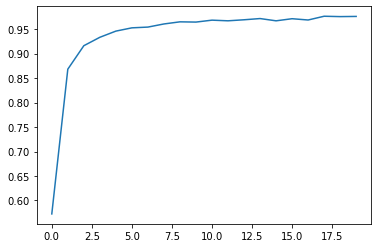

In [53]:
plt.plot(h.history['accuracy'])

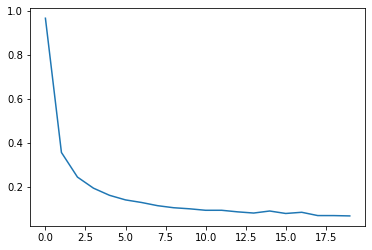

In [54]:
plt.plot(h.history['loss'])

In [55]:
model.evaluate(X_test[:-16], to_categorical(y_test[:-16]), batch_size=batch_size)

62/62 [==============================] - 1s 3ms/step - loss: 0.0677 - accuracy: 0.9742


[0.06771403551101685, 0.9741935729980469]

In [63]:
y_pred = model.predict(X_test[:-16])
y_pred.argmax(axis=2)[:2]

array([[2, 3, 1, 4, 0],
       [3, 4, 0, 2, 1]])

In [64]:
y_pred.argmax(axis=1)[:2]

array([[4, 2, 0, 1, 3],
       [2, 4, 3, 0, 1]])

In [65]:
y_pred[:2]

array([[[1.95994488e-15, 7.32870958e-13, 1.00000000e+00, 2.03669651e-10,
         1.86818898e-15],
        [5.11307847e-14, 7.70976359e-04, 2.27170531e-05, 9.99206364e-01,
         1.80407230e-13],
        [5.58974830e-14, 9.99803364e-01, 1.75673903e-11, 1.96607361e-04,
         1.47792321e-08],
        [2.81388766e-11, 7.99212779e-11, 7.98059188e-12, 1.66119306e-11,
         1.00000000e+00],
        [1.00000000e+00, 1.03194432e-11, 1.41443053e-12, 7.94064033e-13,
         4.32093554e-12]],

       [[7.90344962e-14, 2.93210958e-14, 2.84444709e-14, 1.00000000e+00,
         3.97566603e-14],
        [1.67425057e-07, 1.26761518e-10, 1.72512241e-10, 1.19063825e-08,
         9.99999762e-01],
        [9.99937534e-01, 1.88662020e-15, 5.25645592e-05, 7.65974944e-14,
         9.89420823e-06],
        [3.69718300e-08, 2.51385274e-10, 1.00000000e+00, 1.78863196e-12,
         1.18890522e-11],
        [2.98811496e-11, 1.00000000e+00, 6.21249449e-12, 1.53376254e-13,
         7.64900459e-13]]], dtype=

In [62]:
y_test[:2]

array([[2, 3, 1, 4, 0],
       [3, 4, 0, 2, 1]])

In [216]:
X_test[:2]

array([[[0.92081218, 0.92081218, 0.92081218, 0.92081218],
        [0.4964467 , 0.4964467 , 0.4964467 , 0.4964467 ],
        [1.        , 1.        , 1.        , 1.        ],
        [0.69949239, 0.69949239, 0.69949239, 0.69949239],
        [0.86294416, 0.86294416, 0.86294416, 0.86294416]],

       [[0.7755418 , 0.7755418 , 0.7755418 , 0.7755418 ],
        [0.88390093, 0.88390093, 0.88390093, 0.88390093],
        [0.33900929, 0.33900929, 0.33900929, 0.33900929],
        [1.        , 1.        , 1.        , 1.        ],
        [0.25232198, 0.25232198, 0.25232198, 0.25232198]]])

In [217]:
y_pos = order(X_test[..., 0])
y_idx = order(X_test[..., 0], True)

In [218]:
np.equal(y_pos, y_test).sum()

10000

In [37]:
# y_pred = model.predict(X_test)

In [588]:
# np.equal(y_idx, y_pred.argmax(axis=1)).sum() / np.product(y_test.shape) 

0.9685

In [38]:
# np.equal(y_pos, y_pred.argmax(axis=2)).sum() / np.product(y_test.shape)

In [39]:
# y_pred = model.predict([[[1.0], [1.0], [0.5], [0.2], [0.2]]])
# y_pred.argmax(axis=2), y_pred.argmax(axis=1)

In [40]:
# y_pred = model.predict([[[1.0], [1.0], [1.0], [1.0], [1.0]]])
# y_pred.argmax(axis=2), y_pred.argmax(axis=1)

In [28]:
# cell = PointerLSTMCell(hidden_units)
# dec, _, _ = RNN(cell, name='decoder', return_sequences=True, return_state=True) \
#                     (enc, initial_state=[state_h, state_c], constants=enc)

In [29]:
# enc, state = K.zeros((32, 5, 64)), [K.zeros((32, 64)), K.zeros((32, 64))]
# p = PointerLSTM(64, return_sequences=True, return_state=True, name='decoder')
# _ = p.call(enc, initial_state=state, constants=[enc])

In [43]:
units = 2
att = Attention(units)
X_enc = K.constant( np.random.random((1, 5, units)) )
X_dec = K.constant( np.random.random((1, units)) )

# mask =  K.constant( [[False, False, False, True, True]] )
scores = att(X_enc, X_dec, mask=None)
scores

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.3171001 , 0.18902096, 0.16251951, 0.10216902, 0.2291904 ]],
      dtype=float32)>